# Variational Autoencoder (VAE) for Anomaly Detection

This notebook implements a VAE for anomaly detection with the following specific features:
1.  **Synthetic Data**: High-dimensional data with a **distinct anomaly cluster**.
2.  **VAE Architecture**: PyTorch implementation with reparameterization.
3.  **Hyperparameter Sweep**: Analyzing impact of **$\beta$** (KL weight) and **Latent Dimension**.
4.  **Advanced Evaluation**: AUC-ROC, **AUC-PR**, and **Optimal Threshold Selection** based on F1-score.

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score, classification_report
import matplotlib.pyplot as plt

# Set random seed
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

## 1. Data Generation: Distinct Anomaly Cluster

We generate 5000 samples with 10 features.
- **Normal Data**: Generated from a mixture of 3 Gaussian blobs.
- **Anomalies (2-3%)**: Generated from a **separate, distinct Gaussian cluster** (shifted mean) to ensure they form a coherent group rather than just random noise.

In [3]:
def generate_synthetic_data(n_samples=5000, n_features=20, anomaly_ratio=0.03, random_state=42):
    np.random.seed(random_state)
    
    n_anomalies = int(n_samples * anomaly_ratio)
    n_normal = n_samples - n_anomalies
    
    # 1. Normal Data: 3 Centers
    X_normal, _ = make_blobs(n_samples=n_normal, n_features=n_features, centers=3, cluster_std=1.0, random_state=random_state)
    
    # 2. Anomalies: A Distinct Cluster
    # We shift the mean significantly to create a separate cluster
    anomaly_mean = 4.0  # Shifted away from standard blob centers (usually -10 to 10)
    X_anomalies = np.random.normal(loc=anomaly_mean, scale=1.5, size=(n_anomalies, n_features))
    
    # Combine
    X = np.vstack([X_normal, X_anomalies])
    y = np.hstack([np.zeros(n_normal), np.ones(n_anomalies)])
    
    # Scaling
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True, stratify=y, random_state=random_state)
    
    # To Tensors
    X_train_tensor = torch.FloatTensor(X_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)
    
    return X_train_tensor, X_test_tensor, y_test_tensor, n_features

# Generate Data
X_train, X_test, y_test, N_FEATURES = generate_synthetic_data()

# DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(TensorDataset(X_train, X_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

print(f"Data Ready. Features: {N_FEATURES}. Anomalies: {y_test.sum()} / {len(y_test)}")

Data Ready. Features: 20. Anomalies: 30.0 / 1000


## 2. VAE Architecture

Standard VAE with `reparameterize` method. Loss is customizable via `beta`.

In [4]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=10):
        super(VAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)
        
        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim // 2)
        self.fc4 = nn.Linear(hidden_dim // 2, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return self.fc_mu(h2), self.fc_logvar(h2)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc4(h3))
        return torch.sigmoid(self.fc5(h4))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

def loss_function(recon_x, x, mu, logvar, beta=1.0):
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

## 3. Hyperparameter Sweep & Training

We sweep over:
- **Beta**: `[0.1, 1.0, 5.0]`
- **Latent Dim**: `[2, 5, 10]`

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(beta, latent_dim, epochs=20):
    model = VAE(input_dim=N_FEATURES, hidden_dim=32, latent_dim=latent_dim).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    
    for epoch in range(epochs):
        for data, _ in train_loader:
            data = data.to(DEVICE)
            optimizer.zero_grad()
            recon, mu, logvar = model(data)
            loss, _, _ = loss_function(recon, data, mu, logvar, beta=beta)
            loss.backward()
            optimizer.step()
    return model

def evaluate_model(model, test_loader):
    model.eval()
    mse_scores = []
    labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(DEVICE)
            recon, _, _ = model(data)
            loss_per_sample = torch.sum((recon - data)**2, dim=1)
            mse_scores.extend(loss_per_sample.cpu().numpy())
            labels.extend(target.cpu().numpy())
            
    return np.array(mse_scores), np.array(labels)

## 4. Results & Analysis

We iterate through all configurations, calculate metrics, and find the optimal threshold for the best config.

In [6]:
results = []
BETAS = [0.1, 1.0, 5.0]
LATENT_DIMS = [2, 5, 10]

print(f"{'Beta':<6} | {'Latent':<6} | {'AUC-ROC':<8} | {'AUC-PR':<8} | {'Best F1':<8}")
print("-"*50)

best_f1_global = 0
best_config = None
best_scores = None
best_labels = None

for beta in BETAS:
    for ld in LATENT_DIMS:
        model = train_model(beta, ld)
        scores, labels = evaluate_model(model, test_loader)
        
        # Metrics
        roc_auc = mult_auc_roc = 0
        fpr, tpr, _ = roc_curve(labels, scores)
        roc_auc = auc(fpr, tpr)
        
        precision, recall, thresholds = precision_recall_curve(labels, scores)
        auc_pr = average_precision_score(labels, scores)
        
        # Find Best F1 for this Model
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_f1_local = np.max(f1_scores)
        
        print(f"{beta:<6} | {ld:<6} | {roc_auc:.4f}   | {auc_pr:.4f}   | {best_f1_local:.4f}")
        
        results.append({
            'beta': beta,
            'latent_dim': ld,
            'auc_roc': roc_auc,
            'auc_pr': auc_pr,
            'best_f1': best_f1_local
        })
        
        if best_f1_local > best_f1_global:
            best_f1_global = best_f1_local
            best_config = (beta, ld)
            best_scores = scores
            best_labels = labels

print(f"\nBest Configuration: Beta={best_config[0]}, Latent Dim={best_config[1]} with F1={best_f1_global:.4f}")

Beta   | Latent | AUC-ROC  | AUC-PR   | Best F1 
--------------------------------------------------
0.1    | 2      | 0.9803   | 0.4699   | 0.5934
0.1    | 5      | 0.9938   | 0.7204   | 0.8060
0.1    | 10     | 0.9906   | 0.6913   | 0.7429
1.0    | 2      | 0.9315   | 0.1709   | 0.3974
1.0    | 5      | 0.8653   | 0.2686   | 0.3226
1.0    | 10     | 0.8538   | 0.2160   | 0.2268
5.0    | 2      | 0.8434   | 0.2142   | 0.2373
5.0    | 5      | 0.8533   | 0.2311   | 0.2545
5.0    | 10     | 0.8633   | 0.2811   | 0.3077

Best Configuration: Beta=0.1, Latent Dim=5 with F1=0.8060


## 5. Optimal Threshold & Final Visualization

For the best performing model, we visualize the separation and the trade-offs.

Optimal Anomaly Threshold: 0.708892

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99       970
     Anomaly       0.72      0.87      0.79        30

    accuracy                           0.99      1000
   macro avg       0.86      0.93      0.89      1000
weighted avg       0.99      0.99      0.99      1000



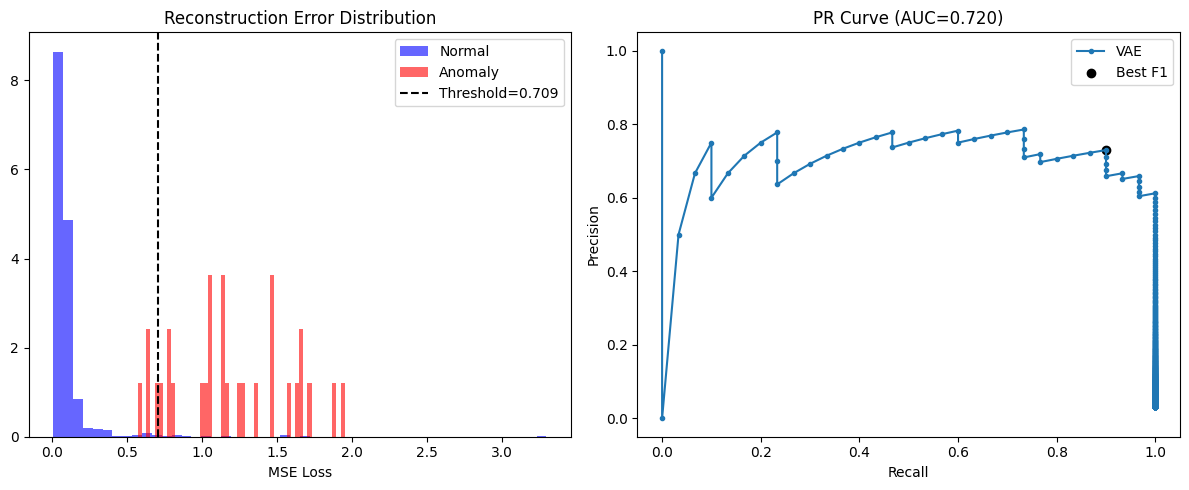

In [7]:
# Re-calculate precision-recall for best model to get threshold
precision, recall, thresholds = precision_recall_curve(best_labels, best_scores)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[best_idx]

print(f"Optimal Anomaly Threshold: {optimal_threshold:.6f}")

# Print Classification Report at Optimal Threshold
predicted_labels = (best_scores > optimal_threshold).astype(int)
print("\nClassification Report:")
print(classification_report(best_labels, predicted_labels, target_names=['Normal', 'Anomaly']))

plt.figure(figsize=(12, 5))

# 1. Reconstruction Error Histogram
plt.subplot(1, 2, 1)
plt.hist(best_scores[best_labels==0], bins=50, alpha=0.6, label="Normal", color='blue', density=True)
plt.hist(best_scores[best_labels==1], bins=50, alpha=0.6, label="Anomaly", color='red', density=True)
plt.axvline(optimal_threshold, color='k', linestyle='--', label=f'Threshold={optimal_threshold:.3f}')
plt.title("Reconstruction Error Distribution")
plt.xlabel("MSE Loss")
plt.legend()

# 2. Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, marker='.', label='VAE')
plt.scatter(recall[best_idx], precision[best_idx], marker='o', color='black', label='Best F1')
plt.title(f"PR Curve (AUC={average_precision_score(best_labels, best_scores):.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()